In [1]:
import numpy as np
from scipy import ndimage
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
offset_count=10
image_dim = 8

#Number of rotated axes 
direction_count = 8000

# Generating voxel plot to be reconstructed

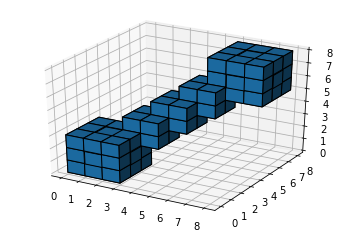

In [3]:
len=8
x, y, z = np.indices((len, len, len))

# Draw cuboids and a link between them
cube1 = (x < 3) & (y < 3) & (z < 3)
cube2 = (x >= 5) & (y >= 5) & (z >= 5)
link = abs(x - y) + abs(y - z) + abs(z - x) <= 3

# Combine the objects into a single boolean array
voxels = cube1 | cube2 | link

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.voxels(voxels, edgecolor='k')
plt.show()

# Generating reconstruction matrix A

In [4]:
# Generate a set of coordinate matrices to be used for matrix rotation
def generate_coordinates(image_dim,offset):
    X, Y = np.mgrid[:image_dim, :image_dim].astype(np.float64)
    center = image_dim*offset
    X += 0.5 - center
    Y += 0.5 - center
    return X, Y

# Split the 3D image into a series of 2d slices along the z-axis, and generate a reconstrution matrix for each slice

def generate_A(img_dim, dirn_count, index, offset_count):
    # Dimensions of the design matrix A:  number of rays(rotated axes) used * offset count X total of number of pixels in image
    A = np.zeros((dirn_count*offset_count,img_dim**2))
    onesmat = np.ones((img_dim, img_dim))
    angles = np.linspace(0, np.pi, dirn_count, endpoint=False)
    offsets=np.linspace(0,1,offset_count)
    vox = voxels[:,:,index]
    for l,offset in enumerate(offsets):
        X, Y = generate_coordinates(img_dim,offset_count)
        for i, angle in enumerate(angles):
            # Create a matrix rotated by angle, xor with a ones matrix to get matrix with all zeros except along one axis
            Xrot = np.round(np.cos(angle) * X - np.sin(angle) * Y)
            Xrot = 1*np.logical_xor(Xrot, onesmat)
            Arow = np.ravel(np.multiply(vox, Xrot))
            A[l*offset_count+2+i,:] = Arow
        # Here,the true image is vectorized as a result of which data_y is also vectorized
    data_y = A @ vox.ravel()[:, np.newaxis]
    return data_y, A


# Run Ridge Regression and display images

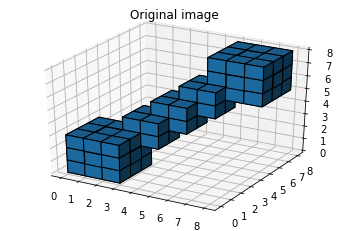

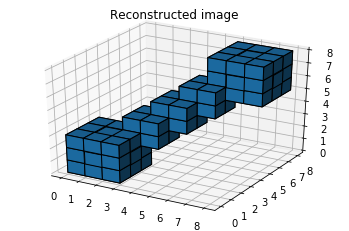

In [5]:

rec_l2 = np.zeros((image_dim, image_dim, image_dim))

# Run ridge regression with lambda = 0.01 for each slice of the 3D image
for j in range(image_dim):
    data_y, A_mat = generate_A(image_dim, direction_count, j, offset_count)
    rgr_ridge = Ridge(alpha=0.0001)
    rgr_ridge.fit(A_mat, data_y.ravel()[:, np.newaxis])
    # The reconstructed image will be vectorized as the true image was vectorized 
    # This will need to be de-vectorised. Hence the reshaping
    rec_l2[:,:,j] = rgr_ridge.coef_.reshape(image_dim, image_dim)
                      
fig1 = plt.figure() 
ax1 = fig1.gca(projection='3d')
ax1.voxels(voxels, edgecolor='k')
plt.title('Original image')


fig2 = plt.figure()
ax2 = fig2.gca(projection='3d')
ax2.voxels(rec_l2, edgecolor='k')
plt.title('Reconstructed image')

plt.show()